# BE - Benign Equivalized

In [1]:
import numpy as np
from numpy import genfromtxt, argmax
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
import pandas as pd
import re
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score, mean_absolute_error, matthews_corrcoef, roc_curve, auc,RocCurveDisplay

import tensorflow as tf
from keras import regularizers
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (27, 10)
# plt.rcParams["xtick.labelsize"] = 10
sns.set_context('paper', font_scale=2)

In [2]:
def calculate_classifications(y_p, y, a): #calculate correct and wrong classifications by attack category
    y_p = y_p.flatten()
    df= pd.DataFrame({'pred':y_p, 'label':y, 'attack':a})
    df['misclassification'] = df.apply(f, axis=1)
    df = df[df['attack']!='Benign']
    attacks = df['attack'].unique()
    att_dic_w = dict((n, 0) for n in attacks)
    att_dic_c = att_dic_w.copy()
    count_series = df.groupby(['attack', 'misclassification']).size()
    print(count_series)
    for key in attacks:
        counts = count_series.get(key).to_list()
        print(counts)
        if count_series.get(key).get(0) == None:
            counts.insert(0,0)
        elif count_series.get(key).get(1) == None:
            counts.insert(1,0)
        att_dic_w[key] = counts[1]
        att_dic_c[key] = counts[0]
    return att_dic_w, att_dic_c

def plot_roc_auc(y_true_oboa, y_true_rboa, y_pred_oboa, y_pred_rboa):
    ns_probs = [0 for _ in range(len(y_true_oboa))]
    
    #calculate fpr, tpr & thesholds for oboa, rboa, random
    fpr_oboa, tpr_oboa, thresholds_oboa = roc_curve(y_true_oboa, y_pred_oboa)
    fpr_rboa, tpr_rboa, thresholds_rboa = roc_curve(y_true_rboa, y_pred_rboa)
    fpr_rand, tpr_rand, thresholds_rand = roc_curve(y_true_oboa, ns_probs)
    
    #auc calculation
    auc_oboa = auc(fpr_oboa, tpr_oboa)    
    auc_rboa = auc(fpr_rboa, tpr_rboa)
    auc_rand = auc(fpr_rand, tpr_rand)
    print('OBOA: ROC AUC=%.3f' % (auc_oboa))
    print('RBOA: ROC AUC=%.3f' % (auc_rboa))
    print('Random: ROC AUC=%.3f' % (auc_rand))
    
    #plot data
    plt.plot(fpr_oboa, tpr_oboa, marker='.', label='OBOA')
    plt.plot(fpr_rboa, tpr_rboa, marker='.', label='RBOA')
    plt.plot(fpr_rand, tpr_rand, linestyle='--', label='0.5')    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def plot_attack_classifications(att_dic_w, att_dic_c): #plot correct and wrong classifications by attack category
    width = 0.4
    keys = att_dic_w.keys()
    values_w = att_dic_w.values()
    values_c = att_dic_c.values()
    x = np.arange(len(keys))
    fig, ax = plt.subplots()
    r1 = ax.bar(x - width/2, values_w, width, label = "Misclassified")
    r2 = ax.bar(x + width/2, values_c, width, label = "Correct Classification")
    ax.set_ylabel('Count')
    ax.set_xlabel('Attack')
    ax.set_title('Classification by Attack')
    ax.set_xticks(x)
    ax.set_xticklabels(keys)
    ax.legend()
    ax.bar_label(r1, padding=3)
    ax.bar_label(r2, padding=3)
    plt.xticks(rotation=45, ha='right')
    fig.tight_layout()
#     plt.rcParams["figure.figsize"] = (30, 10)
#     plt.rcParams["xtick.labelsize"] = 10
    plt.show()
    
#https://stackoverflow.com/questions/42528921/how-to-prevent-overlapping-x-axis-labels-in-sns-countplot
def attack_report(y, y_p, a):
    att_dic_w, att_dic_c = calculate_classifications(y_p, y, a)
    plot_attack_classifications(att_dic_w, att_dic_c)


def f(row):
    if row['pred'] != row['label']:
        val = 1
    else: val = 0
    return val
    
def print_cm(y_test,y_pred_round): #show confusion matrix
    cm = confusion_matrix(y_test,y_pred_round)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Anomaly'])
    disp = disp.plot(include_values=True, cmap = 'Blues')
    print(cm)
#     plt.rcParams["figure.figsize"] = (30, 10)
    plt.show()
    
def print_metrics(y_test,y_pred_round): #print basic metrics
    f1 = f1_score(y_test, y_pred_round, average='binary')
    acc = accuracy_score(y_test, y_pred_round)
    prec = precision_score(y_test, y_pred_round, average='binary')
    recall = recall_score(y_test, y_pred_round, average = 'binary')
    mcc = matthews_corrcoef(y_test, y_pred_round)
    print('accuracy: ',acc)
    print('f1: ', f1)
    print('precision: ', prec)
    print('recall: ', recall)
    print('mcc: ', mcc)
    
def training_report(train_model): #plot acc and loss vs epochs
    loss_vals = train_model.history['loss']
    epochs = range(1, len(loss_vals)+1)
#     plt.rcParams["figure.figsize"] = (30, 10)
    validation_loss = train_model.history['val_loss']
    plt.plot(epochs, loss_vals, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    acc_vals = train_model.history['binary_accuracy']
    validation_acc = train_model.history['val_binary_accuracy']
    plt.plot(epochs, acc_vals, label='Training Accuracy')
    plt.plot(epochs, validation_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def test_report(y_test,y_pred_round):
    print_cm(y_test,y_pred_round)
    print_metrics(y_test,y_pred_round)

# Data Index

- X_train, y_train - Training data from 3 datasets 
- X_test, y_test - Test data from 3 datasets 
- X_val, y_val - Validation data from 3 datasets 
- X_1, y_1 - 1 datasets, test phase 2 data

In [3]:
folder_oboa = 'oboa\\'
name_tail_oboa = '_oboa'
folder_rboa = 'rboa\\'
name_tail_rboa = '_rboa'
dnnfolder = 'RF_Models\\'

RFs = ['e01.pkl', 'e02.pkl', 'e03.pkl', 'e11.pkl', 'e21.pkl']

# AR Test Set (Benign Equalized)

In [4]:
X_1_oboa = np.load(folder_oboa +'X_1_ar.npy')
y_1_oboa = np.load(folder_oboa +'y_1_ar.npy')


X_1_rboa = np.load(folder_rboa +'X_1_ar.npy')
y_1_rboa = np.load(folder_rboa +'y_1_ar.npy')

print('-----------------------------------------\n\n')
c=0
dnn_file_oboa_0 = 'oboa-' + RFs[c]
dnn_file_rboa_0 = 'rboa-' + RFs[c]
print(dnn_file_oboa_0, '\n')
DNN = pickle.load(open(dnnfolder+dnn_file_oboa_0, 'rb'))
y_pred_oboa_0 = DNN.predict_proba(X_1_oboa)[:,1]
DNN = pickle.load(open(dnnfolder+dnn_file_rboa_0, 'rb'))
y_pred_rboa_0 = DNN.predict_proba(X_1_rboa)[:,1]

print('-----------------------------------------\n\n')
c=1
dnn_file_oboa_1 = 'oboa-' + RFs[c]
dnn_file_rboa_1 = 'rboa-' + RFs[c]
print(dnn_file_oboa_1, '\n')
DNN = pickle.load(open(dnnfolder+dnn_file_oboa_1, 'rb'))
y_pred_oboa_1 = DNN.predict_proba(X_1_oboa)[:,1]
DNN = pickle.load(open(dnnfolder+dnn_file_rboa_1, 'rb'))
y_pred_rboa_1 = DNN.predict_proba(X_1_rboa)[:,1]

print('-----------------------------------------\n\n')
c=2
dnn_file_oboa_2 = 'oboa-' + RFs[c]
dnn_file_rboa_2 = 'rboa-' + RFs[c]
print(dnn_file_oboa_2, '\n')
DNN = pickle.load(open(dnnfolder+dnn_file_oboa_2, 'rb'))
y_pred_oboa_2 = DNN.predict_proba(X_1_oboa)[:,1]
DNN = pickle.load(open(dnnfolder+dnn_file_rboa_2, 'rb'))
y_pred_rboa_2 = DNN.predict_proba(X_1_rboa)[:,1]

print('-----------------------------------------\n\n')
c=3
dnn_file_oboa_3 = 'oboa-' + RFs[c]
dnn_file_rboa_3 = 'rboa-' + RFs[c]
print(dnn_file_oboa_3, '\n')
DNN = pickle.load(open(dnnfolder+dnn_file_oboa_3, 'rb'))
y_pred_oboa_3 = DNN.predict_proba(X_1_oboa)[:,1]
DNN = pickle.load(open(dnnfolder+dnn_file_rboa_3, 'rb'))
y_pred_rboa_3 = DNN.predict_proba(X_1_rboa)[:,1]

-----------------------------------------


oboa-e01.pkl 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  7.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   21.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:  2.8min finished


-----------------------------------------


oboa-e02.pkl 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  9.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  7.0min finished


-----------------------------------------


oboa-e03.pkl 



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   25.7s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:  4.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   18.9s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:  3.4min finished


-----------------------------------------


oboa-e11.pkl 



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   24.3s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:  3.8min
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  5.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   18.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  4.1min finished


-----------------------------------------


oboa-e21.pkl 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  4.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.8min finished


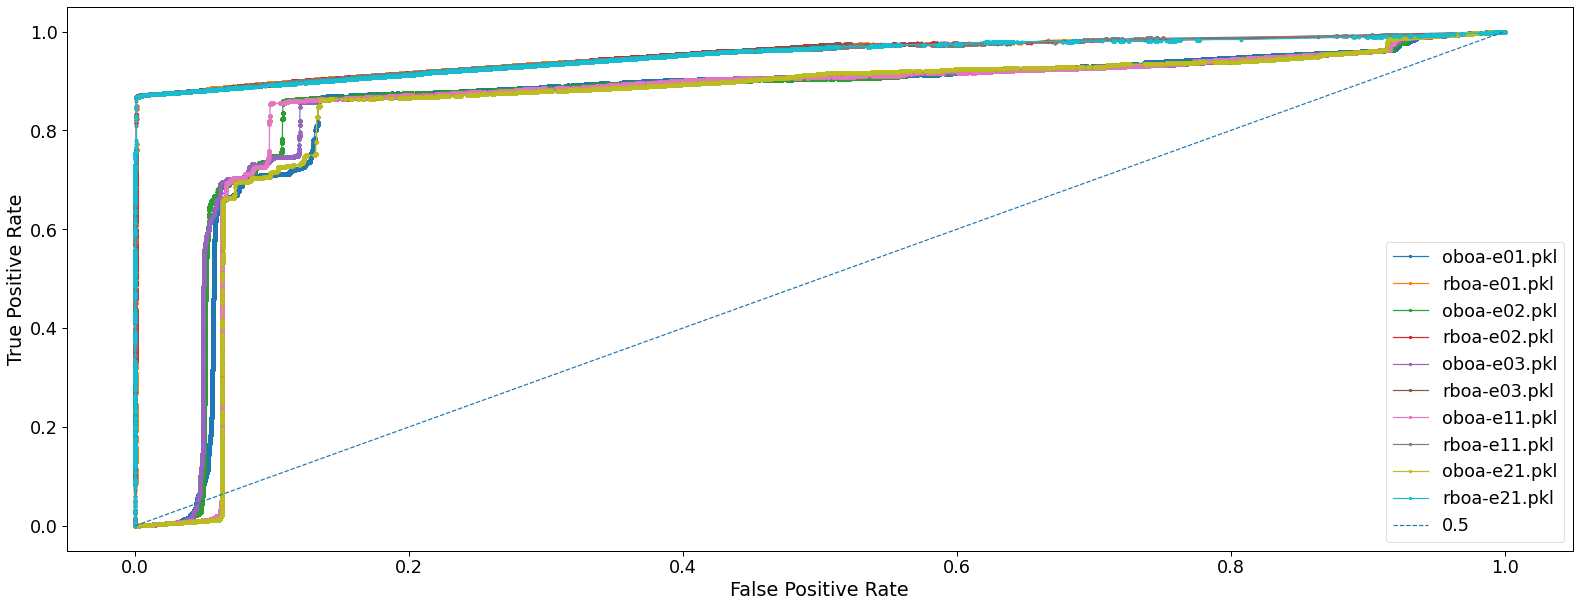

In [5]:
print('-----------------------------------------\n\n')
c=4
dnn_file_oboa_4 = 'oboa-' + RFs[c]
dnn_file_rboa_4 = 'rboa-' + RFs[c]
print(dnn_file_oboa_4, '\n')
DNN = pickle.load(open(dnnfolder+dnn_file_oboa_4, 'rb'))
y_pred_oboa_4 = DNN.predict_proba(X_1_oboa)[:,1]
DNN = pickle.load(open(dnnfolder+dnn_file_rboa_4, 'rb'))
y_pred_rboa_4 = DNN.predict_proba(X_1_rboa)[:,1]




ns_probs = [0 for _ in range(len(y_1_oboa))]

#calculate fpr, tpr & thesholds for oboa, rboa, random
fpr_rand, tpr_rand, thresholds_rand = roc_curve(y_1_oboa, ns_probs)

fpr_oboa_0, tpr_oboa_0, thresholds_oboa_0 = roc_curve(y_1_oboa, y_pred_oboa_0)
fpr_rboa_0, tpr_rboa_0, thresholds_rboa_0 = roc_curve(y_1_rboa, y_pred_rboa_0)

fpr_oboa_1, tpr_oboa_1, thresholds_oboa_1 = roc_curve(y_1_oboa, y_pred_oboa_1)
fpr_rboa_1, tpr_rboa_1, thresholds_rboa_1 = roc_curve(y_1_rboa, y_pred_rboa_1)

fpr_oboa_2, tpr_oboa_2, thresholds_oboa_2 = roc_curve(y_1_oboa, y_pred_oboa_2)
fpr_rboa_2, tpr_rboa_2, thresholds_rboa_2 = roc_curve(y_1_rboa, y_pred_rboa_2)

fpr_oboa_3, tpr_oboa_3, thresholds_oboa_3 = roc_curve(y_1_oboa, y_pred_oboa_3)
fpr_rboa_3, tpr_rboa_3, thresholds_rboa_3 = roc_curve(y_1_rboa, y_pred_rboa_3)

fpr_oboa_4, tpr_oboa_4, thresholds_oboa_4 = roc_curve(y_1_oboa, y_pred_oboa_4)
fpr_rboa_4, tpr_rboa_4, thresholds_rboa_4 = roc_curve(y_1_rboa, y_pred_rboa_4)

#plot data
plt.plot(fpr_oboa_0, tpr_oboa_0, marker='.', label=dnn_file_oboa_0)
plt.plot(fpr_rboa_0, tpr_rboa_0, marker='.', label=dnn_file_rboa_0)

plt.plot(fpr_oboa_1, tpr_oboa_1, marker='.', label=dnn_file_oboa_1)
plt.plot(fpr_rboa_1, tpr_rboa_1, marker='.', label=dnn_file_rboa_1)

plt.plot(fpr_oboa_2, tpr_oboa_2, marker='.', label=dnn_file_oboa_2)
plt.plot(fpr_rboa_2, tpr_rboa_2, marker='.', label=dnn_file_rboa_2)

plt.plot(fpr_oboa_3, tpr_oboa_3, marker='.', label=dnn_file_oboa_3)
plt.plot(fpr_rboa_3, tpr_rboa_3, marker='.', label=dnn_file_rboa_3)

plt.plot(fpr_oboa_4, tpr_oboa_4, marker='.', label=dnn_file_oboa_4)
plt.plot(fpr_rboa_4, tpr_rboa_4, marker='.', label=dnn_file_rboa_4)

plt.plot(fpr_rand, tpr_rand, linestyle='--', label='0.5')    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Test Set